In [6]:
!mkdir -p ~/.kaggle

In [7]:
!mv kaggle.json ~/.kaggle/

In [8]:
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets list


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data            Extrovert vs. Introvert Behavior Data                    31277  2025-06-13 14:26:48.303000          18579        405  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025         Global AI Job Market & Salary Trends 2025               529004  2025-06-01 07:20:49.537000           6887        111  0.9411765        
adilshamim8/social-media-addiction-vs-relationships             Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          17872        272  1.0              


In [11]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.04G/1.06G [00:03<00:00, 249MB/s]
100% 1.06G/1.06G [00:03<00:00, 319MB/s]


In [15]:
!unzip /content/dogs-vs-cats.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/dogs/dog.4419.jpg  
  inflating: /content/train/dogs/dog.442.jpg  
  inflating: /content/train/dogs/dog.4420.jpg  
  inflating: /content/train/dogs/dog.4421.jpg  
  inflating: /content/train/dogs/dog.4422.jpg  
  inflating: /content/train/dogs/dog.4424.jpg  
  inflating: /content/train/dogs/dog.4425.jpg  
  inflating: /content/train/dogs/dog.4426.jpg  
  inflating: /content/train/dogs/dog.4427.jpg  
  inflating: /content/train/dogs/dog.4431.jpg  
  inflating: /content/train/dogs/dog.4433.jpg  
  inflating: /content/train/dogs/dog.4436.jpg  
  inflating: /content/train/dogs/dog.4438.jpg  
  inflating: /content/train/dogs/dog.4439.jpg  
  inflating: /content/train/dogs/dog.444.jpg  
  inflating: /content/train/dogs/dog.4440.jpg  
  inflating: /content/train/dogs/dog.4441.jpg  
  inflating: /content/train/dogs/dog.4442.jpg  
  inflating: /content/train/dogs/dog.4443.jpg  
  inflating: /content/train/dogs/dog.44

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


## Setting up Path

In [17]:
#placeholder for the directory path
cat_directory_path='/content/data/train/cat'
dog_directory_path='/content/data/train/dog'

## Initializing the Generator

## Follow this if you have Seperate Folder

train_dir=vaidation_path=image_size=(224,224)batch_size=100

## Data Augmentation for the Training Set

train_datagen=ImageDataGenerator(rescale=1/./255,
 rotation_range=20,
 width_shift_range=0.2,
 height_shift_range=0.2,
 horizontal_flip=True,
 fill_mode='nearest'
)

## Validation data without augmentation

validation_datagen=ImageDataGenerator(rescale=1./255)

## Generate Data Generators

train_generator=train_datagen.flow_from_directory(train_dir,target_size=image_size,batch_size=batch_size,class_mode='binary')

validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=image_size,batch_size=batch_size,class_mode='binary')

In [18]:
#Set path to the dataset
data_dir='/content/dogs_vs_cats/train'

#Hyperparameters
img_width,img_height=224,224 #AlexNet input size
batch_size=32
epochs=20
validation_split=0.2 #20% of the data for the validation purpose

In [19]:
#Load datasets
train_dataset=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='training',
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.


Last time we have used flow_from_dataframe , to uske liye images_dataset_from_directory bata diye hai


In [21]:
validation_dataset=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset='validation',
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [22]:
#Data Augmentation layer
#Ye train dataset pe hi kiya jaat hai
data_augmentation=tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

In [23]:
#Apply data augmentation only on the training part
train_dataset=train_dataset.map(lambda x,y:(data_augmentation(x,training=True),y))

Prefetch-

32 Images-pass to model training,
load next batch of 32 images and -Pass to model training.

In [24]:
#Performance Optimization of the GPU
#Prefecth the datasets for the Performance
AUTOTUNE=tf.data.AUTOTUNE
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset=validation_dataset.prefetch(buffer_size=AUTOTUNE)

Before diving into the specifics of AUTOTUNE .It's important to understand the role of data pipelines.

Data Loading: The Process of reading data from storage (eg. Disk) . PreProcessing Operations like resizeing , normalization , ect. that are applied to the data before feeding to the model . Batching Grouping individual examples into batches for efficient preprocessing .

Prefetching: Loading the next batch of data while the current one is being proceeded by the model , to enser that the GPU/CPU is always busy , A well optimized data pipeline ensers that the model trainng process is not waiting for data , which would slow down the training.

## Let's Build AlexNet Model

In [25]:
print(img_width,img_height)

224 224


In [26]:
alexnet_model=Sequential([

    Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),activation='relu',input_shape=(img_width,img_height,3)),
    MaxPooling2D(pool_size=(3,3),strides=(2,2)),

    Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(3,3),strides=(2,2)),

    Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),

    MaxPooling2D(pool_size=(3,3),strides=(2,2)),

    Flatten(),

    Dense(4096,activation='relu'),
    Dropout(0.5),
    Dense(4096,activation='relu'),
    Dropout(0.5),

    Dense(1,activation='sigmoid'),
])

#Ek baar ye dekhlena ki last me Dense(1 h kyu hai)

#Agar aapke pass multiclasssification hai to just change the last line jo dense wala hai

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compile the Model

In [27]:
#Compile the model
alexnet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

## Model training

In [28]:
history=alexnet_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 218s 414ms/step - accuracy: 0.5359 - loss: 1.0597 - val_accuracy: 0.6087 - val_loss: 0.7003
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 253s 412ms/step - accuracy: 0.6124 - loss: 0.6598 - val_accuracy: 0.7042 - val_loss: 0.5811
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 273s 434ms/step - accuracy: 0.6613 - loss: 0.6181 - val_accuracy: 0.6930 - val_loss: 0.5973
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 251s 413ms/step - accuracy: 0.6772 - loss: 0.6023 - val_accuracy: 0.7465 - val_loss: 0.5247
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 268s 426ms/step - accuracy: 0.7076 - loss: 0.5687 - val_accuracy: 0.7327 - val_loss: 0.5325


In [29]:
#Evaluate the model on validation data
val_loss,val_accuracy=alexnet_model.evaluate(validation_dataset)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.7370 - loss: 0.5351
Validation Accuracy: 73.27%


In [30]:
alexnet_model.save("saved_model_5_epochs.keras")

In [33]:
alexnet_model = build_alexnet_model()  # define this function or reinitialize the model
alexnet_model.load_weights("model_5_weights.h5")


NameError: name 'build_alexnet_model' is not defined

## Why do we save weights

->because you might want to create one more new architechture, but usually people save hi krte hai

## Mode save_weights?

save_weights se hum bas weights sav ekrte na ki architecture save krte


but wahi agar humlog model.save krte to whole architechture ko save krta hai

In [35]:
#load the Model
from tensorflow.keras.models import load_model
loaded_model=load_model("saved_model_5_epochs.keras")
#Now you can use the loaded model for inferene or further training

In [36]:
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,253,317 (535.02 MB)

 Trainable params: 46,751,105 (178.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 93,502,212 (356.68 MB)

In [37]:
history=loaded_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=1,
)

500/500 ━━━━━━━━━━━━━━━━━━━━ 211s 412ms/step - accuracy: 0.7080 - loss: 0.5605 - val_accuracy: 0.7495 - val_loss: 0.5223


In [38]:
history_dict=history.history
history_dict

{'accuracy': [0.7162500023841858],
 'loss': [0.550529420375824],
 'val_accuracy': [0.7494999766349792],
 'val_loss': [0.5223338603973389]}

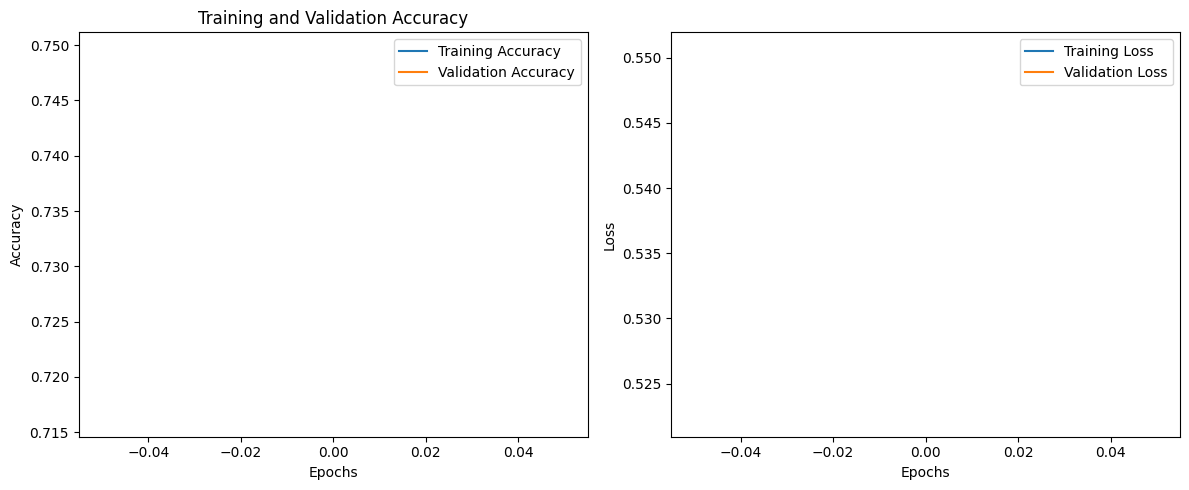

In [39]:
#Assuming you have a 'history' object returned from model.fit from model.fit()
histroy_dict=history.history #Access the histrou dictionary

#Plotting Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(histroy_dict['accuracy'],label='Training Accuracy')
plt.plot(histroy_dict['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


#Plotting loss
plt.subplot(1,2,2)
plt.plot(histroy_dict['loss'],label='Training Loss')
plt.plot(histroy_dict['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#show plots
plt.tight_layout()
plt.show()


## Building LeNet Model

In [41]:
#LeNet Model
lenet_model=Sequential([
    Conv2D(32,(5,5),activation='tanh',input_shape=(img_width,img_height,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64,(5,5),activation='tanh'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(120,activation='tanh'),
    Dense(84,activation='sigmoid'),
])
#Do debug it like i just missed it ...